In [20]:
%load_ext autoreload
%load_ext Cython
%autoreload
%matplotlib inline

import pandas as pd
import numpy as np
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook
import texcrapy
#from konlpy.corpus import word
from ckonlpy.tag import Twitter, Postprocessor
from konlpy.tag import Hannanum
import json
from soynlp.word import WordExtractor
from soynlp.tokenizer import MaxScoreTokenizer, LTokenizer
from soynlp.noun import LRNounExtractor_v2
import nltk
from nltk import Text
from nltk.corpus import stopwords as STOPWORDS
from nltk.corpus import words as WORDS
from nltk.tag import untag
import math
import os
import re

from threading import Thread
#from multiprocessing import Process
import dask
from dask import compute, delayed
import dask.multiprocessing
import dask.bag as db
import jpype

from gensim.models import Word2Vec, FastText
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

import seaborn as sns
from matplotlib import rcParams
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation

from wordcloud import WordCloud

sns.set(style='ticks')
rcParams['font.family'] = u'Malgun Gothic'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [2]:
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sejin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Sejin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Scraping

In [175]:
df = pd.read_excel('keywords and logos.xlsx', sheet_name='20190215')[['shortname','kw_supporter','kw_supported','keywords']]; df
_or = lambda kw: ' OR '.join(['#' + k.strip() for k in kw.split(',')])

qry_base = {row.shortname:_or(row.keywords) for row in df.itertuples()}
supporters = df.shortname[df.kw_supporter==True]
qry_sup = ' OR '.join([qry_base[sup] for sup in supporters]); qry_sup
qry = {row.shortname: '(' + qry_base[row.shortname] + ') AND (' + qry_sup + ')' if row.kw_supported==True else qry_base[row.shortname] for row in df.itertuples()}

In [ ]:
%%time
what = ['id', 'timestamp', 'text']
texcrapy.scrap(qry, what=what, lang='ko', end='2019-01-31', download_to='scrapped/twitter')

# Making Corpus

In [3]:
def preproc(text, remove_url=True, remove_mention=True, remove_hashtag=False):
    LINEBREAK = r'\n' # str.replace에서는 r'\n'으로 검색이 안된다
    RT = '((?: rt)|(?:^rt))[^ @]?'
    EMOJI = r'[\U00010000-\U0010ffff]'
    DOTS = '…'
    LONG_BLANK = r'[ ]+'
    SPECIALS = r'([^ a-zA-Z0-9_\u3131-\u3163\uac00-\ud7a3]+)|([ㄱ-ㅣ]+)'
    
    # \u3131-\u3163\uac00-\ud7a3 는 한글을 의미함
    # URL = r'(?P<url>(https?://)?(www[.])?[^ \u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b([^ \u3131-\u3163\uac00-\ud7a3]*))'
    URL1 = r'(?:https?:\/\/)?(?:www[.])?[^ :\u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b(?:[^ \u3131-\u3163\uac00-\ud7a3]*)'
    URL2 = r'pic.twitter.com/[a-zA-Z0-9_]+'
    URL = '|'.join((URL1, URL2))
    
    HASHTAG = r'#(?P<inner_hashtag>[^ #@]+)'
    MENTION = r'@(?P<inner_mention>[^ #@]+)' 
    
    #PTNS = '|'.join((LINEBREAK, RT, URL, HASHTAG, MENTION, EMOJI))
    
    #out = {}
    #text = re.sub('|'.join((LINEBREAK, RT, EMOJI, DOTS, SPECIALS)), '', text.lower())
    text = text.lower()
    
    if remove_url:
        text = re.sub(URL, ' ', text)

    if remove_mention:
        text = re.sub(MENTION, ' ', text)        
    else:
        text = re.sub(MENTION, ' \g<inner_mention>', text)
        
    if remove_hashtag:
        text = re.sub(HASHTAG, ' ', text)
    else:
        text = re.sub(HASHTAG, ' \g<inner_hashtag>', text)
        
    text = re.sub('|'.join((LINEBREAK, RT, EMOJI, DOTS, SPECIALS)), ' ', text)
    return re.sub(LONG_BLANK, ' ', text).strip()
    

class JsonCorpus:
    def __init__(self, *fnames, textkey='text'):
        self.fnames = fnames
        self.textkey = textkey
        self.corpus = self._corpus()
        
    def _corpus(self):
        corpus = {}
        nfiles = len(self.fnames)
        
        for i, fname in enumerate(self.fnames):
            with open(fname, encoding='UTF-8-sig') as f:                
                for item, docs in json.load(f).items():
                    corpus[item] = [preproc(doc[self.textkey]) for doc in docs]
                
                pct = '%.2f' % (100 * (i+1) / nfiles)
                print('\r {pct}% completed'.format(pct=pct), end='')
                
        return corpus
    
                
    def __iter__(self):
        for sents in self.corpus.values():
            yield from sents

    def __len__(self):
        return sum([len(sents) for sents in self.corpus.values()])
    
    def tokenize(self, tagger):
        return Tokens(tagger, **self.corpus)
    
    
def do_concurrent_tagging(item, corpus, n_items, tokens):
    jpype.attachThreadToJVM()    
    #tokens[item] = [[tok[0].replace(' - ', '') for tok in tagger.pos(corp)] for corp in corpus]
    
    _tokens = [[tok[0].replace(' - ', '') for tok in tagger.pos(corp)] for corp in corpus]
    tokens.append(_tokens)
    
    pct = '%.2f' % (100 * len(tokens) / n_items)
    print('\r [ {item} ] {pct}% completed         '.format(item=item, pct=pct), end='')
    return
    
    
class Tokens:
    def __init__(self, tagger, **corpora):
        self.tagger = tagger
        self.tokensdict = self._get_tokens2(**corpora)
    
    
    def _get_tokens(self, **corpora):
        tokens = [] #{}
        ths = []
        n_items = len(corpora)
        
        for item, corpus in list(corpora.items())[:50]:
            th = Thread(target=do_concurrent_tagging, args=(item, corpus, n_items, tokens))
            ths.append(th)
            
        for th in ths: th.start()
        for th in ths: th.join()
        
        print('\n')
        return tokens
    
    
    def _get_tokens2(self, **corpora):
        tokens = {}
        for item, corpus in tqdm_notebook(list(corpora.items())[:]):
            tokens[item] = [
                [
                    #(tok[0].replace(' - ', ''), tok[1]) for tok in self.tagger.pos(corp)
                    tok[0].replace(' - ', '') for tok in self.tagger.pos(corp)
                ] 
                for corp in corpus
            ]
        return tokens
    
    
    def freq(self):
        return {
            item: Text(sum(toks, [])).vocab() 
            for item, toks in tqdm_notebook(self.tokensdict.items())
            if item not in ['ootd','fashion','category']
        }
                
    def __iter__(self):
        for toks in self.tokensdict.values():
            yield from toks
            
    def __len__(self):
        return sum([len(toks) for toks in self.tokensdict.values()])    

In [4]:
%%time
fnames = ['scrapped/twitter/' + fname for fname in os.listdir('scrapped/twitter')]
jcorpus = JsonCorpus(*fnames)

 100.00% completedWall time: 2min 12s


In [12]:
jcorpus.corpus['crocs'];

# Making Dictionary

### 1. From Scraping keywords

In [5]:
df_keywords = pd.read_excel('keywords and logos.xlsx', sheet_name='20190215')['keywords']
keywords = {w.strip() for w in ', '.join(df_keywords).split(',')}

### 2. Soynlp nouns

In [6]:
noun_extractor = LRNounExtractor_v2(verbose=True)
_soynouns = noun_extractor.train_extract(jcorpus)

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=1260, neg=1173, common=12
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 493329 from 429969 sents. mem=0.341 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=6680411, mem=1.450 Gb
[Noun Extractor] batch prediction was completed for 112092 words
[Noun Extractor] checked compounds. discovered 106245 compounds
[Noun Extractor] postprocessing detaching_features : 128251 -> 117025
[Noun Extractor] postprocessing ignore_features : 117025 -> 116918
[Noun Extractor] postprocessing ignore_NJ : 116918 -> 116458
[Noun Extractor] 116458 nouns (106245 compounds) with min frequency=1
[Noun Extractor] flushing was done. mem=1.543 Gb                    
[Noun Extractor] 75.49 % eojeols are covered


In [7]:
freq_atleast = 5
soynouns = {k for k,v in _soynouns.items() if v.frequency>=freq_atleast}
soyngrams = {v for k,v in noun_extractor._compounds_components.items() if k in soynouns}

### 3. Korean words

In [8]:
with open('dic_system.txt', encoding='UTF-8-sig') as f:
    lines = f.readlines()
    
kowords = set() #{tok.split('\t')[0] for tok in lines}

### 4. English words

In [9]:
enwords = set(WORDS.words())

### 5. Custom words

In [11]:
cwords = '''
    주구장창, 셀스타그램, literide, 재고정리, kids, 하지만, uhd, snsd, 빛내, 키네스, yoona, lahaina, 발휘, 윤아, 
    클락스, station, jeju, asap, 침대, fedex, usps, 초근접, 상상, 
'''

#     이벤트, 스포츠, 이투데이, 보좌진, 홍보수석, 체리핑, 체리핑크, 기업, 오니츠카, 오니츠카타이거, 
#     마일드세븐, 세븐일레븐, 1949년, 오니츠카기하치로, 운동화, 2013, 시세이도, 
#     농구화, 제조회사, 1977년, 깔맞춤, 황금비율, 
#     주행거리, 인스파이어, 구입, 오니츠카슬립온, 계속, 생각, 맥시코66, 마라톤화,  hajiwon, 
#     연예인, kimchiu, 다시한번, 마린시티, 참가신청, 완료, 제주도, 게이밍, 운동스타그램, 아름다운, 러닝화, 미션완료, 
#     크리스마스선물, 아이제아, 질주본능, 어짜피, 소유욕, 뽀대욕, 
#     1990년, 보라매공원, 이름값, 이성경, 디자인, 베이스볼, 스파이크, 한그루, 토리브엔터테인먼트, 다방구, 재밌는추억, 
#     패션쇼, 스키니진, 프로젝트, 의상학, tryout, 크리스마스, 얼스타그램, 셀스타그램, 콜라보, 
#     selfie, 아스크림, 들기름, 에어맥스, 2008, 뭐시기, 이미테이션, 게다가, 
#     우먼스, 하의실종, 준비물, 1994년, 패스트, 오프화이트, 인스타, 팬도럼, 


cwords = set(re.findall(r'[^ ,]+', re.sub(r'\n', '', cwords)))

### 4. Twitter dictionary

In [12]:
twitter = Twitter()
newwords = list(keywords | soynouns | kowords | enwords | cwords)
twitter.add_dictionary(newwords, 'Noun')

C:\ProgramData\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [17]:
twitter.pos('oh! sejinkang 컴퓨터로 돌리니까 뭐라고그러냐')

[('oh', 'Noun'),
 ('!', 'Punctuation'),
 ('se', 'Noun'),
 ('jink', 'Noun'),
 ('a', 'Noun'),
 ('ng', 'Noun'),
 ('컴퓨터', 'Noun'),
 ('로', 'Josa'),
 ('돌리', 'Verb'),
 ('니까', 'Noun'),
 ('뭐라', 'Noun'),
 ('고', 'Josa'),
 ('그', 'Noun'),
 ('러', 'Noun'),
 ('냐', 'Josa')]

In [22]:
Hannanum().tagset

{'E': '어미',
 'EC': '연결 어미',
 'EF': '종결 어미',
 'EP': '선어말어미',
 'ET': '전성 어미',
 'F': '외국어',
 'I': '독립언',
 'II': '감탄사',
 'J': '관계언',
 'JC': '격조사',
 'JP': '서술격 조사',
 'JX': '보조사',
 'M': '수식언',
 'MA': '부사',
 'MM': '관형사',
 'N': '체언',
 'NB': '의존명사',
 'NC': '보통명사',
 'NN': '수사',
 'NP': '대명사',
 'NQ': '고유명사',
 'P': '용언',
 'PA': '형용사',
 'PV': '동사',
 'PX': '보조 용언',
 'S': '기호',
 'X': '접사',
 'XP': '접두사',
 'XS': '접미사'}

# Tagger setup

### 1. Passtags

In [14]:
stoptags = {'Foreign','Punctuation','KoreanParticle','Josa','Eomi','PreEomi','Exclamation','Determiner'}
passtags = set(twitter.tagset.keys()) - stoptags

### 2. Stopwords

In [15]:
stopwords_en = STOPWORDS.words('english')

with open('stopwords-ko.json', encoding='UTF-8-sig') as f:
    stopwords_ko = json.load(f)
    
stopwords_custom = '''
    엔, 줄, 내, 에는, 잖아요, 라는, 데, 는, 것은, 는, 인가요, 란, 말인가, 시, 은, 하네, 이나, 지, 있음, 수, 있는, 
    있으신가, 요, 그렇다면, 하고, 내는, 후, 생, 가거, 한, 하시겠어요, 만, 되네, 하려면, 하다, 랑, 하게, 근데, pic, 님의, 
    호, 하세요, 흑, 적인, 다욧, 니, 보니, 건, 다, 위해, 히, 께, 난, 해, 면서, 용, 보자, 가서, 하는, 중, 도, 
    잉, 인, 울, 하러가기, 인, 준, 든, 이셨으면, 와의, 
    드는, 되네요, 크흐, 이걸, 서, 에도, 됩니다, 하다고, 날, 
    하네요, 했습니다, 해지네요, 이였냐, 더, 
    되니, 하지않을, 아아, htm, 고, 냐고, 이야, 아니야, 너네, 된, 이냐, 해봐라, 해서, 
    vi, 
'''    

stopwords_custom = re.findall(r'[^ ,]+', re.sub(r'\n','',stopwords_custom))
stopwords = set(stopwords_en + stopwords_ko)# + stopwords_custom)

### 3. N-grams

In [16]:
cngrams = {
    ('캘빈','클라인'),('켈빈','클라인'),
}
#     ('the','boyz'),
#     ('어글리','슈즈'),
#     ('리미티드','에디션'),
#     ('키코','코스타디노브'), ('kiko','kostadinov'),
#     ('젤','카야노'),
#     ('젤','라이트'),('gel','lyte'),
#     ('스튜어트','와이츠먼'),
#     ('주니','블랙'),
#     ('jun','hyo','seong'),
#     ('gel','ptg'),
#     ('오니츠카','타이거'),
#     ('노박','조코비치'),
#     ('후디','티셔츠'),
#     ('최종병기','활'),
#     ('아이제아','토마스'),
#     ('gel','ace')
# ]

ngrams = list(cngrams | soyngrams)

In [17]:
tagger = Postprocessor(twitter, stopwords=stopwords, passtags=passtags, ngrams=ngrams)

In [32]:
%%time
tokens = jcorpus.tokenize(tagger)


Wall time: 1h 16min 13s


In [37]:
%%time

def do_concurrent_tagging2(start, end, corpus_list, tokens):
    jpype.attachThreadToJVM()
    
    for i in range(start, end):
        item, corpus = corpus_list[i]
        _tokens = [[tok[0].replace(' - ', '') for tok in tagger.pos(corp)] for corp in corpus]
        tokens.append(_tokens)    
        
        pct = '%.2f' % (100 * len(tokens) / len(corpus_list))
        print('\r [ {item} ] {pct}% completed         '.format(item=item, pct=pct), end='')

    return

if __name__ == '__main__':
    tokens = []
    corpus_list = list(jcorpus.corpus.items())[:50]
    t1 = Thread(target=do_concurrent_tagging2, args=(0, 10, corpus_list, tokens))
    t2 = Thread(target=do_concurrent_tagging2, args=(10, 20, corpus_list, tokens))
    t3 = Thread(target=do_concurrent_tagging2, args=(20, 30, corpus_list, tokens))
    t4 = Thread(target=do_concurrent_tagging2, args=(30, 40, corpus_list, tokens))
    t5 = Thread(target=do_concurrent_tagging2, args=(40, 50, corpus_list, tokens))
    t1.start(); t2.start(); t3.start(); t4.start(); t5.start()
    t1.join(); t2.join(); t3.join(); t4.join(); t5.join()

    print('\n')

 [ adererror ] 46.00% completed                    

KeyboardInterrupt: 

In [30]:
%%time

def do_concurrent(tagger, item, corpus):
    import jpype
    jpype.attachThreadToJVM()
    return item, [untag(tagger.pos(corp)) for corp in corpus]

if __name__ == '__main__':
    values = [delayed(do_concurrent)(tagger, item, corpus) for item, corpus in list(jcorpus.corpus.items())[:5]]
    result = compute(*values, scheduler='processes')

TypeError: can't pickle JavaField objects

In [34]:
from multiprocessing import Process

def test():
    from konlpy.tag import Twitter
    tag = Twitter()
    print(tag.pos("안녕하세요"))


if __name__ == '__main__':
    workers = [Process(target=test) for _ in range(2)]

    for worker in workers:
        worker.start()

    for worker in workers:
        worker.join()

In [77]:
def do_concurrent_tagging(tagger, start, end, lines, result):
    jpype.attachThreadToJVM()
    l = [tagger.pos(lines[i]) for i in range(start, end)]
    result.append(l)
    return

if __name__=="__main__":
    import time

    print('Number of lines in document:')
    k = tagger
    lines = jcorpus.corpus['crocs']
    nlines = len(lines)
    print(nlines)

    print('Batch tagging:')
    s = time.time()
    result = []
    l = [k.pos(line) for line in lines]
    result.append(l)
    t = time.time()
    print(t - s)

    print('Concurrent tagging:') 
    result = []
    t1 = Thread(target=do_concurrent_tagging, args=(k, 0, int(nlines/3), lines, result))
    t2 = Thread(target=do_concurrent_tagging, args=(k, int(nlines/3), int(2*nlines/3), lines, result))
    t3 = Thread(target=do_concurrent_tagging, args=(k, int(2*nlines/3), int(3*nlines/3), lines, result))
    t1.start(); t2.start(); t3.start()
    t1.join(); t2.join(); t3.join()
    
    m = sum(result, []) # Merge results
    print(time.time() - t)

Number of lines in document:
887
Batch tagging:
8.333232641220093
Concurrent tagging:
8.313261270523071


In [72]:
def __tokenize(text):
    #return ' '.join([tok[0].replace(' - ', '') for tok in tagger.pos(text)])
    return ' '.join(untag(tagger.pos(text)))

In [73]:
f_tokenize = np.vectorize(__tokenize)

In [76]:
%%time
aa = f_tokenize(jcorpus.corpus['crocs']);

In [296]:
tokensfreq = tokens.freq()

In [297]:
with open('model/tokensfreq.json', 'w', encoding='UTF-8-sig') as f:
    json.dump(tokensfreq, f, ensure_ascii=False)

In [299]:
tokensfreq;

# Word2vec

In [300]:
w2v = Word2Vec(tokens, size=100, window=5, min_count=10, workers=4, sg=1)
w2v.save('model/word2vec.model')

In [301]:
w2v.init_sims(replace=True)

In [23]:
w2v = Word2Vec.load('model/word2vec.model')

In [16]:
w2v.wv.most_similar(positive=['일관'], topn=30)

[('정상화', 0.9366623163223267),
 ('연행', 0.9274003505706787),
 ('해고노동자들', 0.9217797517776489),
 ('부당함', 0.9191930294036865),
 ('탄압', 0.9191465377807617),
 ('뻔뻔', 0.914584219455719),
 ('코오롱정리해고자', 0.9143577814102173),
 ('복직투쟁', 0.9140615463256836),
 ('해고노동자', 0.9129735231399536),
 ('포위', 0.9097698330879211),
 ('근본', 0.9060238599777222),
 ('노동탄압', 0.905104398727417),
 ('시켜라', 0.9041001796722412),
 ('정리해고투쟁', 0.9022014141082764),
 ('코오롱제품', 0.901553750038147),
 ('종탑', 0.9013911485671997),
 ('정당', 0.8998298645019531),
 ('8년이', 0.8987500667572021),
 ('음주운전', 0.8986541628837585),
 ('부당정리해고', 0.897933304309845),
 ('외침', 0.8967496156692505),
 ('불매동참', 0.8964993953704834),
 ('정치자금', 0.8962012529373169),
 ('외면', 0.8941475749015808),
 ('내몬', 0.8940457105636597),
 ('즉각', 0.8937199711799622),
 ('철폐', 0.8927503824234009),
 ('등산객들', 0.8916171789169312),
 ('유가족', 0.8915675282478333),
 ('코오롱자본', 0.8901481628417969)]

In [30]:
out = {}
idkw = '일관'
for bname in pd.read_excel('keywords and logos.xlsx', sheet_name='20190215')['shortname'].iloc[3:]:
    try:
        out[bname] = w2v.wv.similarity(idkw, bname)
    except:
        pass
    
pd.Series(out).sort_values()

saintlaurent       0.033952
michaelkors        0.038600
bershka            0.041159
hoodbyair          0.062653
givenchy           0.064949
goldengoose        0.070604
hm                 0.072648
diesel             0.073212
benetton           0.073856
calvinklein        0.074835
keds               0.077450
forever21          0.077757
acnestudios        0.081522
thombrowne         0.083636
clubmonaco         0.084461
kangol             0.087877
descente           0.091049
maisonmargiela     0.094338
valentino          0.094530
poloralphlauren    0.094850
jimmychoo          0.095222
marcjacobs         0.095919
rickowens          0.096380
onitsukatiger      0.097182
marceloburlon      0.097341
vivastudio         0.097604
louisvuitton       0.097963
lacoste            0.098998
oioi               0.099232
y3                 0.102051
                     ...   
daks               0.283280
humanmade          0.283617
braindead          0.285018
salomon            0.286463
sketchers          0

In [22]:
pd.read_excel('keywords and logos.xlsx', sheet_name='20190215')['shortname']

0                  ootd
1              category
2               fashion
3              8seconds
4                adidas
5        adidasoriginal
6                 asics
7            balenciaga
8                 bally
9              beanpole
10             benetton
11             blackyak
12             buckaroo
13             burberry
14          calvinklein
15          canadagoose
16               chanel
17                coach
18             converse
19                crocs
20                 daks
21             descente
22               diesel
23                 dior
24                 dkny
25            drmartens
26              eastpak
27                 fila
28                  gap
29             giordano
             ...       
297               rokit
298             salomon
299       seventhheaven
300            someware
301        sssworldcorp
302        stereovinyls
303         studioseven
304              wilson
305        dolcegabbana
306             ragbone
307             

In [306]:
id_pools = {
    '가성비': ['가성비','저렴','효율','성능','실용'], 
    '트렌디': ['유행','트렌드','trend','trendy'],#,'민감'],
    '신뢰성': ['신뢰','믿음','trust','견고','품질','안정','클래식','classic'],
    '럭셔리': ['럭셔리','고급','호화','luxury'], #,'품격'
    '유니크': ['유니크','독특','독창','unique','개성','only','참신','특이'],
    '활동성': ['활동','활발','운동','액티브','스포츠','active','sport','sports','sporty'],
    '과감함': ['과감','선도','선구','대담','강렬','선명','예술','art'],
    # 철학, 정통, 격식, 아이디어, 변화, 변동, 환상, 신상, 새로운, 튀는, 
}

In [307]:
#docs = sum(tokens_dict.values(), [])

In [308]:
dct = Dictionary(tokens)
dct.filter_extremes(no_below=20, no_above=0.2)
dct.compactify()

In [309]:
corp = {item:[dct.doc2bow(tok) for tok in toks] for item, toks in tqdm_notebook(tokens.tokensdict.items())}

In [310]:
model_tfidf = TfidfModel(sum(corp.values(),[]), id2word=dct)

In [311]:
wordlist = list(dct.values())
identities = list(id_pools.keys())
brands = list(tokens.tokensdict.keys())

In [312]:
sim_mat = np.zeros((len(identities),len(wordlist)))
for i, idty in enumerate(tqdm_notebook(identities)):
    for j, word in enumerate(wordlist):
        sims = []
        for w in id_pools[idty]:
            try:
                sims.append(w2v.wv.similarity(w, word))
            except:
                sims.append(0)
        sim_mat[i,j] = np.mean(sims)
        #sim_mat[i,j] = np.mean([w2v.wv.similarity(w, word) for w in id_pools[idty]])

In [313]:
sim_mat.shape

(7, 20489)

In [314]:
def get_brand_vecs(bname):
    brand_tfidf  = model_tfidf[corp[bname]]
    return np.vstack([sparse2full(c, len(dct)) for c in brand_tfidf]).mean(axis=0)

def plot_id(bname):
    val = sim_mat.dot(get_brand_vecs(bname))
    #val /= val.sum()
    pd.Series(val, index=identities).plot.barh()

In [315]:
id_dict = {}
for bname in brands:
    if bname not in ['ootd','fashion','category']:
        try:
            id_dict[bname] = sim_mat.dot(get_brand_vecs(bname))
        except:
            print(bname)

#id_dict = {
#    bname:sim_mat.dot(get_brand_vecs(bname)) 
#    for bname in tqdm_notebook(brands)
#    if bname not in ['ootd','fashion','category']
#}

advisoryboardcrystals
doublet
engineeredgarment
experthorror
goat
heliotemil
ignoredprayers
novacancyinn
onlineceramics
saterdaysnyc
someware
sssworldcorp
ystrdystmrrw


In [316]:
pd.DataFrame(id_dict, index=identities).to_pickle('model/id_dict.pkl')

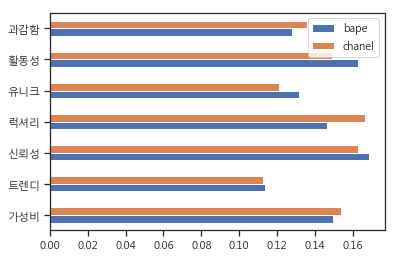

In [317]:
df = pd.read_pickle('model/id_dict.pkl')
df /= df.sum()
df[['bape','chanel']].plot.barh()

# 여기서 normalize 축을 바꾸면 어떨까?

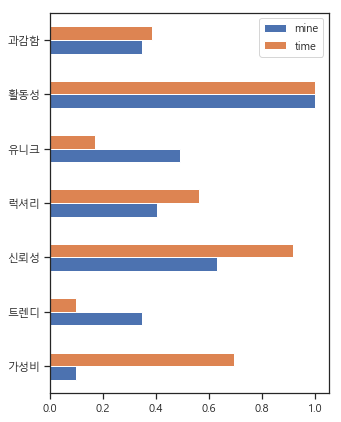

In [5]:
df = pd.read_pickle('model/id_dict.pkl')
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1, 1))
X_train_minmax = min_max_scaler.fit_transform(df)
df2 = df.copy()
df2[:] = X_train_minmax
df2[['mine','time']].plot.barh(figsize=(5,7))

In [ ]:
df2.T

In [319]:
pca = PCA(n_components=0.9)
X_reduced = pca.fit_transform(df2.T)
# cluster = KMeans(n_clusters=10, random_state=0).fit(X_reduced)
# cluster = DBSCAN().fit(X_reduced)
cluster = AffinityPropagation().fit(X_reduced)
clustered = pd.Series(cluster.labels_, index=df2.columns); clustered

032c                     0
1017alyx9sm              1
8seconds                 3
99percentis             10
aape                     2
abecrombiefitch         19
acnestudios              0
acoldwall               16
acronym                  4
adererror               24
adidas                   4
adidasoriginal           1
aecawhite               16
aimeleondore            10
aldo                     3
alexandermcqueen        11
alexanderwang           16
allsaints                4
alphaindustry            4
ambush                  10
ami                     17
amiri                   23
antisocialsocialclub    13
apc                     17
arcteryx                 3
asics                    9
awakeny                 22
balenciaga              21
bally                   23
balmain                 23
                        ..
tomsshoes                8
topshop                 25
topten                   6
toryburch               23
tumi                    23
ugg                      8
u

In [320]:
clrd = pd.DataFrame(clustered.sort_values()).reset_index()
clrd.columns = ['bname', 'cluster']
clrd.to_excel('model/clustered.xlsx')

In [321]:
clrd[clrd.bname=='adidas']

,bname,cluster
62,adidas,4


In [322]:
clustered.index[clustered==9]

Index(['asics', 'descente', 'drmartens', 'eider', 'fila', 'giordano',
       'jansport', 'kangol', 'kolonsport', 'lafuma', 'lmc', 'nepa',
       'newbalance', 'prospecs'],
      dtype='object')

In [323]:
df2.loc['신뢰성']

032c                    0.921131
1017alyx9sm             1.000000
8seconds                0.894010
99percentis             0.773222
aape                    0.975499
abecrombiefitch         0.844910
acnestudios             1.000000
acoldwall               1.000000
acronym                 1.000000
adererror               1.000000
adidas                  0.907210
adidasoriginal          1.000000
aecawhite               1.000000
aimeleondore            0.809190
aldo                    1.000000
alexandermcqueen        1.000000
alexanderwang           1.000000
allsaints               1.000000
alphaindustry           0.916350
ambush                  0.815106
ami                     0.947703
amiri                   0.979774
antisocialsocialclub    0.971174
apc                     0.955957
arcteryx                0.983103
asics                   0.862977
awakeny                 0.987181
balenciaga              1.000000
bally                   0.899009
balmain                 0.930140
          

In [325]:
df_kw = pd.read_excel('keywords and logos.xlsx', sheet_name='20190215')[['shortname','keywords']].set_index('shortname')
df_kw;

In [326]:
def plot_wc(bname):
    with open('model/tokensfreq.json', encoding='UTF-8-sig') as f:
        j = json.load(f)[bname]
        kws = [kw.strip() for kw in df_kw.keywords.loc[bname].split(',')]
        [j.pop(kw, None) for kw in kws]

    x,y = np.ogrid[:300, :300]
    mask = (x-150)**2 + (y-150)**2 > 130**2
    mask = 255 * mask.astype(int)
        
    font_path = r'c:\Windows\Fonts\NanumBarunGothic.ttf'
    wc = WordCloud(width=100, height=100, background_color='white', font_path=font_path, random_state=0, mask=mask)
    
    try:
        fig, ax = plt.subplots(figsize=(7,7))
        ax.imshow(wc.generate_from_frequencies(j), interpolation='bilinear')
        ax.axis('off')
        fig.savefig('model/wordcloud/wc_' + bname + '.png', format='png')
        
    except:
        print(bname)
        
    finally:
        plt.close(fig)

In [327]:
for row in tqdm_notebook(df_kw.itertuples()):
    bname = row.Index
    
    fname = 'model/wordcloud/wc_' + bname + '.png'
    if os.path.isfile(fname):
        continue
        
    if bname not in ['ootd','fashion','category']:
        plot_wc(bname)

doublet
engineeredgarment
ignoredprayers
saterdaysnyc
advisoryboardcrystals
experthorror
goat
heliotemil
novacancyinn
onlineceramics
someware
sssworldcorp
ystrdystmrrw


In [9]:
df2.T['신뢰성'].sort_values()

soup               0.478494
thursdayisland     0.523196
hconnect           0.535815
discovery          0.558666
maxmara            0.597487
fog                0.599294
munsingwear        0.600664
coteciel           0.614565
mine               0.630577
k2                 0.631754
topten             0.649428
bbc                0.657800
buckaroo           0.695261
reigningchamp      0.700859
coach              0.706395
gap                0.710637
mains              0.710886
plac               0.716768
maje               0.718295
placesplusfaces    0.724394
umbro              0.729065
mlb                0.732206
plasticisland      0.739186
topshop            0.745188
charms             0.745581
nonnative          0.750487
lecoqsportif       0.752308
tomboy             0.753768
hoodbyair          0.754262
palace             0.763309
                     ...   
porter             1.000000
everywear          1.000000
montblanc          1.000000
liful              1.000000
carhartt           1